## GeometricErrors - Point Shifting 

For KDD 2021

### Part 1: Loading Data

In [1]:
""" Environment Configuration """

# Source of input tensors. 
data_path = '/data/GeometricErrors/EM'

# Source of original rasters, shapefiles.
source_path ='/data/GeometricErrors/Scene01'

# Label of dataset used (Original = 1, New = 2)
dataset_label = 1

# Path to save EM Test as folder
out_root_dir = '/data/GeometricErrors/tests'

# Enables training with GPU
use_gpu = True
gpus = ['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3']

# Environment Seeds
tf_seed = 2001 # Tensorflow
np_seed = 2001 # Numpy
py_seed = 2001 # Python

# Pre-Load Determiner.
preload = False
#   ^^^
# - True, the candidates are loaded and stored. 
# - False, the candidates are loaded from jupyter persistent storage




# Weights to load when skipping training
std_weight_path = '/data/GeometricErrors/tests/BaselineWeights.h5'


""" Point Shifting Annotator Configuration """

# number of points to generate on BOTH sides of each source point
pairs = 15

# Interval at which shifting vertices are sampled in meters
interval = 10

# Offset distance between coordinate points as they are generated on either side of the source. (meters)
off_dist = 1.5

# Minimum Valid Proability over map
min_probability = 1e-06

# Weight consideration candidate0 line distance between candidate points
length_weight_value = 0

# Buffer in meters to apply to candidates
weight_buffer = 2

buff_dist = 4
# Option to normalize over K^2 (True) or by K (False).
normalize_full = False


""" UNET Config """

# Base learning rate to use in training. Reccomend 0.01
learning_rate = 0.1




""" EM Iteration Config """

# Initial jump-start predicted class map path
seg_class_map_fp = '/data/pmap.tif'

# Number of EM iterations
em_target = 6


# Learning Rate Scheduler
import lib.K_Tools as kt 
lr_schedule = kt.Oscillate_LR

# Optionally Enable notes
prompt_notes = False


/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Std Imports
import os, sys, time, random, csv
from datetime import datetime as dt 

# Module Imports
import tensorflow as tf
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as shp
from tensorflow.keras.optimizers import Adam

# Lib imports
import lib.Doc_Tools as doc
import lib.GeoTools as gt
import lib.Tiling as tile
import lib.K_Tools as kt
from lib.Annotators import *

""" Static Configuration """
# Batch size for training
batch_size = 32
# Early Stopping Patience
es_patience = 20
# Reduce Learning Rate on Plateau: Multiplier to reduce LR by upon plateau
rlop_factor = 0.5
# Adam Optimizer config
adam_epsilon = 1e-8
adam_decay = 1e-5
# Buffer in meters applied to annotations when comparing iou
iou_buffer = 6

# Seed environment
random.seed(py_seed)
tf.random.set_seed(tf_seed)
np.random.seed(np_seed)

# Prompt for notes on test
if prompt_notes:
    test_notes = input("Enter Notes for test: ")
else:
    test_notes = 'Notes have been disabled.'
    
### Create Folder for test documentation
test_idx, test_dir = doc.InitTest(out_root_dir,
                                  em_target=em_target,
                                  LR=learning_rate,
                                  notes=test_notes,
                                  pairs=pairs,
                                  interval=interval,
                                  off_distance=off_dist,
                                  min_p=min_probability,
                                  L=length_weight_value)

### Loading Source
train_raster = rio.open('{}/train_raster.tif'.format(source_path))
test_raster = rio.open('{}/test_raster.tif'.format(source_path))
template_raster = rio.open('{}/template_map.tif'.format(source_path))

gt_labels = gpd.read_file('{}/GroundTruth.shp'.format(source_path))
imp_labels = gpd.read_file('{}/imperfectLines.shp'.format(source_path))

### Loading Tensors
X_train = np.load('{}/X_train.npy'.format(data_path))
Y_train = np.load('{}/Y_train.npy'.format(data_path))

X_val = np.load('{}/X_val.npy'.format(data_path))
Y_val = np.load('{}/Y_val.npy'.format(data_path))

X_test = np.load('{}/X_test.npy'.format(data_path))
Y_test = np.load('{}/Y_test.npy'.format(data_path))


### Loading tile offsets
train_offsets_fp = '{}/train_offsets.csv'.format(data_path)
val_offsets_fp = '{}/val_offsets.csv'.format(data_path)
print("Successfully loaded tensors.")

# Convert All CRS's
imp_labels = imp_labels.to_crs(train_raster.crs)
gt_labels = gt_labels.to_crs(imp_labels.crs)
source_annotation = imp_labels

### Evaluate original Shapefile Precision
source_iou = gt.gdf_iou(gt_labels, imp_labels, iou_buffer)
prev_iou = source_iou

### Create A distributed training strategy for GPU training
if use_gpu:
    mirror_strategy = tf.distribute.MirroredStrategy(devices=gpus)

Successfully loaded tensors.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [3]:
weight_buffer = 4

### Part 1: Baseline Model Training and Evaluation


Preparing UNET model...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0'

Epoch 28/50
88/88 [==============================] - 12s 132ms/step - loss: -0.3322 - accuracy: 0.9306 - f1_score: 0.3318 - dice_coef: 0.3318 - val_loss: -0.1866 - val_accuracy: 0.9283 - val_f1_score: 0.1860 - val_dice_coef: 0.1866 - lr: 0.0063
Epoch 29/50
88/88 [==============================] - 12s 133ms/step - loss: -0.3335 - accuracy: 0.9313 - f1_score: 0.3323 - dice_coef: 0.3324 - val_loss: -0.1855 - val_accuracy: 0.9279 - val_f1_score: 0.1848 - val_dice_coef: 0.1855 - lr: 0.0063
Epoch 30/50
88/88 [==============================] - 12s 132ms/step - loss: -0.3354 - accuracy: 0.9318 - f1_score: 0.3335 - dice_coef: 0.3335 - val_loss: -0.1852 - val_accuracy: 0.9311 - val_f1_score: 0.1836 - val_dice_coef: 0.1852 - lr: 0.0063
Epoch 31/50
88/88 [==============================] - 12s 133ms/step - loss: -0.3405 - accuracy: 0.9317 - f1_score: 0.3392 - dice_coef: 0.3392 - val_loss: -0.1841 - val_accuracy: 0.9305 - val_f1_score: 0.1822 - val_dice_coef: 0.1841 - lr: 0.0063


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Baseline Preformance:
Training Report 00
 - F1_Score: 35.611
 - Dice_Score: 35.605
 - False_Positives: 145485000.000
 - False_Negatives: 721018200.000
 - Precision: 30.811
 - Recall: 42.183
 - Keras_Precision: 47.171
 - Keras_Recall: 15.266
Validation Report 00
 - F1_Score: 29.935
 - Dice_Score: 29.925
 - False_Positives: 8135100.000
 - False_Negatives: 45271500.000
 - Precision: 27.633
 - Recall: 32.656
 - Keras_Precision: 43.924
 - Keras_Recall: 12.339
Testing Report 00
 - F1_Score: 39.686
 - Dice_Score: 39.675
 - False_Positives: 9141300.000
 - False_Negatives: 8062300.000
 - Precision: 38.240
 - Recall: 41.247
 - Keras_Precision: 38.240
 - Keras_Recall: 41.247
 - Confusion Matrix: [[9806564   91413]
 [  80623   56600]]



Sat at 09:19:43PM


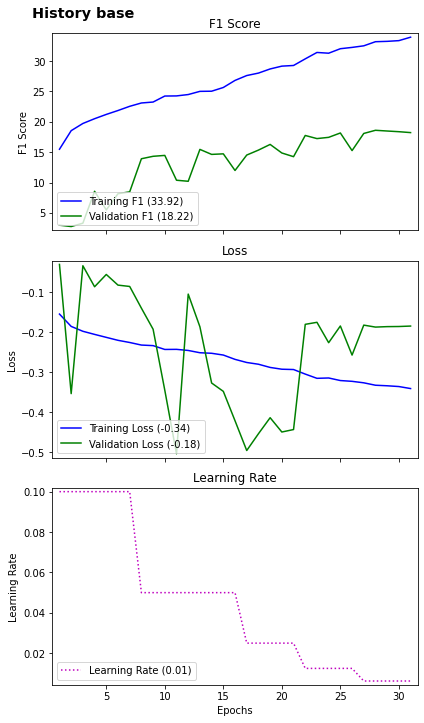

In [4]:
### Baseline Model Training
epochs = 50

# Get timer for baseline training
base_start = time.perf_counter()

# Prepare Baseline Folder
base_folder = os.path.join(test_dir, 'baseline')
if not os.path.exists(base_folder): os.mkdir(base_folder)

# Prepare tensorboard folder
base_tb_dir = os.path.join(base_folder, 'tensorboard')
    
# Prepare Callbacks, including weight output
base_callbacks = kt.SetCallbacks(weights_out=base_folder+'/BaselineWeights.h5', es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path=base_tb_dir)
metrics = [kt.dice_coef,'accuracy', kt.f1_score]
    
if use_gpu:
    with mirror_strategy.scope():
        # Select and Build Model
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

        # Train Model
        baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)
else:
    # Select and Build Model
    model = kt.Get_Model('UNET')
    model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

    # Train Model
    baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)

# Save History plot and csv
doc.plot_history(baseline_results, test_dir=base_folder, config_idx='base')

epochs_used = len(baseline_results.history['accuracy'])

    
""" Evaluate Baseline Model Preformance """
print("Baseline Preformance:")
train_rpt = kt.ModelReport(X_train, Y_train, model, 'Training')
val_rpt = kt.ModelReport(X_val, Y_val, model, 'Validation')
test_rpt = kt.ModelReport(X_test, Y_test, model, 'Testing')

print(dt.now().strftime('\n\n%a at %I:%M:%S%p'))


### Part 2: EM Iteration

`Warning`: By proceeding, the EM Iteration will use the model configured above with the parameters already set. Tune the baseline model above as many times as needed before proceeding.

#### Section 1: Configure EM Test with Annotator

In [5]:
seg_class_map_fp = None
preload = False

In [6]:
# Prepare annotator
annotator = Dynamic_Preloading_Annotator(pairs=pairs,                   # Number of pairs to be linearly generated on either side of the source point 
                                         off_dist=off_dist,             # Interval distance that each new pair is generated
                                         interval=interval,             # Inteval at which new candidate groups are generated
                                         min_p=min_probability,         # Minimum valid probability from class map
                                         L=length_weight_value,         # Weight for line distance
                                         weight_buffer=weight_buffer,   # Buffer to apply to candidates when weighting
                                         normalize_full=normalize_full, # Optionally normalize by K^2 instead of K
                                         )

#copy_anno = annotator

# Preload Candidate Data 
if preload:
    if seg_class_map_fp:
        initial_pmap = rio.open(seg_class_map_fp)
    else:
        initial_pmap = kt.Get_Pmap(source_raster=train_raster, pmodel=model, pmap_fp=None)
    print("PRELOADING")
    all_data = annotator.preload_candidates(source_annotation, initial_pmap)
    %store all_data
    #%store annotator
else:
    %store -r all_data
    #%store -r annotator
    
    # Check the annotators for equivalent configuration
    """bad_keys = []
    for key in ['pairs', 'off_dist', 'interval', 'min_p', 'L', 'weight_buffer', 'normalize_full']:
        if (getattr(annotator, key) != getattr(copy_anno, key)):
            bad_keys.append(key)
    if len(bad_keys) > 0:
        raise RuntimeError("Annotators have {} incompatible keys: {}\nCandidates must be regenerated. Configure this in the first block.".format(len(bad_keys),bad_keys))
    
    """
    print("Loaded candidate_data")
    
    
# Prepare performance storage
em_dict = {
    'Name': ['Base'],
    'Test_Data': [test_rpt],
    'Train_Data': [train_rpt],
    'Val_Data': [val_rpt],
    'Line_IoU': [np.round((source_iou*100), 2)],
    'Epochs': [epochs_used],
    'LR': [learning_rate],
    'Training_Time': ['{:.3f} s'.format(time.perf_counter() - base_start)],
    'Update_Time': ['NA'],
}

# Prepare EM iterator index.
EM_iterator = 0

# Prepare storage for top F1 and IoU
top_f1, top_f1_idx = 0, 0
top_iou, top_iou_idx = 0, 0


Loaded candidate_data


In [7]:
buff_dist = 4

em_target = 10

#### Run EM Iteration

Beginning Iteration, Target steps: 10

EM Step 00 begun.
Sat at 09:20:03PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 00)
Sat at 09:20:31PM

Created New Annotation. (Step 00)
Sat at 09:22:59PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 00)
Sat at 09:23:04PM

New Learning Rate: 0.100000. (Step 00)
Preparing UNET model...
UNET model built successfully.

Training model...
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
Completed model Training. (Step 00)
Sat at 09:30:38PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 01
 - F1_Score: 47.177
 - Dice_Score: 47.175
 - False_Positives: 22412500.000
 - False_Negatives: 2567400.000
 - Precision: 33.231
 - Recall: 81.290
 - Keras_Precision: 33.231
 - Keras_Recall: 81.290
 - Confusion Matrix: [[9673852  224125]
 [  25674  111549]]

Training Report 01
 - F1_Score: 53.881
 - Dice_Score: 53.880
 - False_Positives: 214421900.000
 - False_Negatives: 714328900.000
 - Precision: 45.895
 - Recall: 65.232
 - Keras_Precision: 58.701
 - Keras_Recall: 29.906
Validation Report 01
 - F1_Score: 42.251
 - Dice_Score: 42.255
 - False_Positives: 14406400.000
 - False_Negatives: 47126200.000
 - Precision: 37.345
 - Recall: 48.642
 - Keras_Precision: 50.960
 - Keras_Recall: 24.108

New Top F1: 47.18

New Top IoU: 21.18

EM Step (00) Complete on Sat at 09:31:04PM
- Annotation IoU:     21.18
	- Source Improvement: +2.92
	- Step Improvement:   +2.92

------ Times ---------------------
- Class Map Generation: 27.645 s
- Annotation Update:    139.524 s
- Model Traini

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 02
 - F1_Score: 49.202
 - Dice_Score: 49.197
 - False_Positives: 18856600.000
 - False_Negatives: 3092600.000
 - Precision: 36.050
 - Recall: 77.463
 - Keras_Precision: 36.050
 - Keras_Recall: 77.463
 - Confusion Matrix: [[9709411  188566]
 [  30926  106297]]

Training Report 02
 - F1_Score: 59.411
 - Dice_Score: 59.409
 - False_Positives: 159022200.000
 - False_Negatives: 718067500.000
 - Precision: 53.452
 - Recall: 66.864
 - Keras_Precision: 64.840
 - Keras_Recall: 28.997
Validation Report 02
 - F1_Score: 44.791
 - Dice_Score: 44.796
 - False_Positives: 11303400.000
 - False_Negatives: 47618000.000
 - Precision: 42.367
 - Recall: 47.509
 - Keras_Precision: 54.823
 - Keras_Recall: 22.364

New Top F1: 49.20

New Top IoU: 24.30

EM Step (01) Complete on Sat at 09:40:49PM
- Annotation IoU:     24.30
	- Source Improvement: +6.04
	- Step Improvement:   +3.12

------ Times ---------------------
- Class Map Generation: 24.999 s
- Annotation Update:    143.097 s
- Model Traini

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 03
 - F1_Score: 51.426
 - Dice_Score: 51.430
 - False_Positives: 14733200.000
 - False_Negatives: 3873000.000
 - Precision: 40.066
 - Recall: 71.776
 - Keras_Precision: 40.066
 - Keras_Recall: 71.776
 - Confusion Matrix: [[9750645  147332]
 [  38730   98493]]

Training Report 03
 - F1_Score: 65.890
 - Dice_Score: 65.890
 - False_Positives: 120429400.000
 - False_Negatives: 715044100.000
 - Precision: 61.568
 - Recall: 70.864
 - Keras_Precision: 70.990
 - Keras_Recall: 29.185
Validation Report 03
 - F1_Score: 50.312
 - Dice_Score: 50.314
 - False_Positives: 8376200.000
 - False_Negatives: 47925100.000
 - Precision: 50.568
 - Recall: 50.059
 - Keras_Precision: 62.769
 - Keras_Recall: 22.760

New Top F1: 51.43

New Top IoU: 27.49

EM Step (02) Complete on Sat at 09:52:39PM
- Annotation IoU:     27.49
	- Source Improvement: +9.23
	- Step Improvement:   +3.19

------ Times ---------------------
- Class Map Generation: 25.635 s
- Annotation Update:    139.229 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 04
 - F1_Score: 54.496
 - Dice_Score: 54.497
 - False_Positives: 15840700.000
 - False_Negatives: 2650000.000
 - Precision: 41.141
 - Recall: 80.688
 - Keras_Precision: 41.141
 - Keras_Recall: 80.688
 - Confusion Matrix: [[9739570  158407]
 [  26500  110723]]

Training Report 04
 - F1_Score: 67.707
 - Dice_Score: 67.707
 - False_Positives: 117023500.000
 - False_Negatives: 709153700.000
 - Precision: 63.038
 - Recall: 73.123
 - Keras_Precision: 71.932
 - Keras_Recall: 29.722
Validation Report 04
 - F1_Score: 54.069
 - Dice_Score: 54.067
 - False_Positives: 8022900.000
 - False_Negatives: 47449400.000
 - Precision: 54.122
 - Recall: 54.015
 - Keras_Precision: 64.421
 - Keras_Recall: 23.439

New Top F1: 54.50

New Top IoU: 30.11

EM Step (03) Complete on Sat at 10:01:58PM
- Annotation IoU:     30.11
	- Source Improvement: +11.86
	- Step Improvement:   +2.63

------ Times ---------------------
- Class Map Generation: 25.452 s
- Annotation Update:    139.949 s
- Model Traini

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 05
 - F1_Score: 58.594
 - Dice_Score: 58.590
 - False_Positives: 12863100.000
 - False_Negatives: 2706200.000
 - Precision: 46.133
 - Recall: 80.279
 - Keras_Precision: 46.133
 - Keras_Recall: 80.279
 - Confusion Matrix: [[9769346  128631]
 [  27062  110161]]

Training Report 05
 - F1_Score: 72.678
 - Dice_Score: 72.678
 - False_Positives: 79830200.000
 - False_Negatives: 721626200.000
 - Precision: 71.732
 - Recall: 73.650
 - Keras_Precision: 78.491
 - Keras_Recall: 28.759
Validation Report 05
 - F1_Score: 57.625
 - Dice_Score: 57.624
 - False_Positives: 5209500.000
 - False_Negatives: 47938400.000
 - Precision: 63.084
 - Recall: 53.036
 - Keras_Precision: 72.190
 - Keras_Recall: 22.003

New Top F1: 58.59

New Top IoU: 32.20

EM Step (04) Complete on Sat at 10:13:48PM
- Annotation IoU:     32.20
	- Source Improvement: +13.94
	- Step Improvement:   +2.09

------ Times ---------------------
- Class Map Generation: 25.322 s
- Annotation Update:    140.996 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 06
 - F1_Score: 58.716
 - Dice_Score: 58.714
 - False_Positives: 11703800.000
 - False_Negatives: 3155400.000
 - Precision: 47.448
 - Recall: 77.005
 - Keras_Precision: 47.448
 - Keras_Recall: 77.005
 - Confusion Matrix: [[9780939  117038]
 [  31554  105669]]

Training Report 06
 - F1_Score: 75.017
 - Dice_Score: 75.017
 - False_Positives: 60672600.000
 - False_Negatives: 725671800.000
 - Precision: 76.717
 - Recall: 73.390
 - Keras_Precision: 82.343
 - Keras_Recall: 28.052
Validation Report 06
 - F1_Score: 58.963
 - Dice_Score: 58.963
 - False_Positives: 5171500.000
 - False_Negatives: 48202100.000
 - Precision: 64.543
 - Recall: 54.272
 - Keras_Precision: 72.870
 - Keras_Recall: 22.370

New Top F1: 58.72

New Top IoU: 33.49

EM Step (05) Complete on Sat at 10:25:32PM
- Annotation IoU:     33.49
	- Source Improvement: +15.23
	- Step Improvement:   +1.28

------ Times ---------------------
- Class Map Generation: 25.363 s
- Annotation Update:    140.368 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 07
 - F1_Score: 60.379
 - Dice_Score: 60.377
 - False_Positives: 11741800.000
 - False_Negatives: 2710400.000
 - Precision: 48.396
 - Recall: 80.248
 - Keras_Precision: 48.396
 - Keras_Recall: 80.248
 - Confusion Matrix: [[9780559  117418]
 [  27104  110119]]

Training Report 07
 - F1_Score: 78.819
 - Dice_Score: 78.818
 - False_Positives: 52312700.000
 - False_Negatives: 711926300.000
 - Precision: 80.051
 - Recall: 77.625
 - Keras_Precision: 84.900
 - Keras_Recall: 29.236
Validation Report 07
 - F1_Score: 64.907
 - Dice_Score: 64.904
 - False_Positives: 4438100.000
 - False_Negatives: 47214200.000
 - Precision: 70.432
 - Recall: 60.186
 - Keras_Precision: 76.982
 - Keras_Recall: 23.918

New Top F1: 60.38

New Top IoU: 34.33

EM Step (06) Complete on Sat at 10:39:22PM
- Annotation IoU:     34.33
	- Source Improvement: +16.07
	- Step Improvement:   +0.85

------ Times ---------------------
- Class Map Generation: 26.327 s
- Annotation Update:    143.657 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 08
 - F1_Score: 61.065
 - Dice_Score: 61.060
 - False_Positives: 10385400.000
 - False_Negatives: 3126400.000
 - Precision: 50.502
 - Recall: 77.217
 - Keras_Precision: 50.502
 - Keras_Recall: 77.217
 - Confusion Matrix: [[9794123  103854]
 [  31264  105959]]

Training Report 08
 - F1_Score: 76.896
 - Dice_Score: 76.896
 - False_Positives: 47464200.000
 - False_Negatives: 730061700.000
 - Precision: 80.850
 - Recall: 73.311
 - Keras_Precision: 85.372
 - Keras_Recall: 27.507
Validation Report 08
 - F1_Score: 66.498
 - Dice_Score: 66.503
 - False_Positives: 3678500.000
 - False_Negatives: 47163300.000
 - Precision: 74.036
 - Recall: 60.352
 - Keras_Precision: 79.903
 - Keras_Recall: 23.670

New Top F1: 61.07

New Top IoU: 35.00

EM Step (07) Complete on Sat at 10:48:44PM
- Annotation IoU:     35.00
	- Source Improvement: +16.74
	- Step Improvement:   +0.66

------ Times ---------------------
- Class Map Generation: 25.336 s
- Annotation Update:    142.006 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 09
 - F1_Score: 62.781
 - Dice_Score: 62.781
 - False_Positives: 10580900.000
 - False_Negatives: 2602900.000
 - Precision: 51.241
 - Recall: 81.032
 - Keras_Precision: 51.241
 - Keras_Recall: 81.032
 - Confusion Matrix: [[9792168  105809]
 [  26029  111194]]

Training Report 09
 - F1_Score: 78.910
 - Dice_Score: 78.910
 - False_Positives: 47656300.000
 - False_Negatives: 719452400.000
 - Precision: 81.578
 - Recall: 76.412
 - Keras_Precision: 85.788
 - Keras_Recall: 28.563
Validation Report 09
 - F1_Score: 66.648
 - Dice_Score: 66.648
 - False_Positives: 3503500.000
 - False_Negatives: 47579900.000
 - Precision: 75.108
 - Recall: 59.901
 - Keras_Precision: 80.547
 - Keras_Recall: 23.365

New Top F1: 62.78

New Top IoU: 36.17

EM Step (08) Complete on Sat at 11:01:22PM
- Annotation IoU:     36.17
	- Source Improvement: +17.91
	- Step Improvement:   +1.18

------ Times ---------------------
- Class Map Generation: 25.445 s
- Annotation Update:    140.018 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 10
 - F1_Score: 59.773
 - Dice_Score: 59.771
 - False_Positives: 9372000.000
 - False_Negatives: 3878200.000
 - Precision: 51.228
 - Recall: 71.738
 - Keras_Precision: 51.228
 - Keras_Recall: 71.738
 - Confusion Matrix: [[9804257   93720]
 [  38782   98441]]

Training Report 10
 - F1_Score: 78.785
 - Dice_Score: 78.784
 - False_Positives: 49124100.000
 - False_Negatives: 717367900.000
 - Precision: 80.997
 - Recall: 76.690
 - Keras_Precision: 85.443
 - Keras_Recall: 28.670
Validation Report 10
 - F1_Score: 66.053
 - Dice_Score: 66.055
 - False_Positives: 3716500.000
 - False_Negatives: 47059900.000
 - Precision: 73.305
 - Recall: 60.107
 - Keras_Precision: 79.837
 - Keras_Recall: 23.821

EM Step (09) Complete on Sat at 11:15:16PM
- Annotation IoU:     35.17
	- Source Improvement: +16.92
	- Step Improvement:   -1.00

------ Times ---------------------
- Class Map Generation: 27.812 s
- Annotation Update:    142.354 s
- Model Training:       623.992 s
- Model Evaluation:  

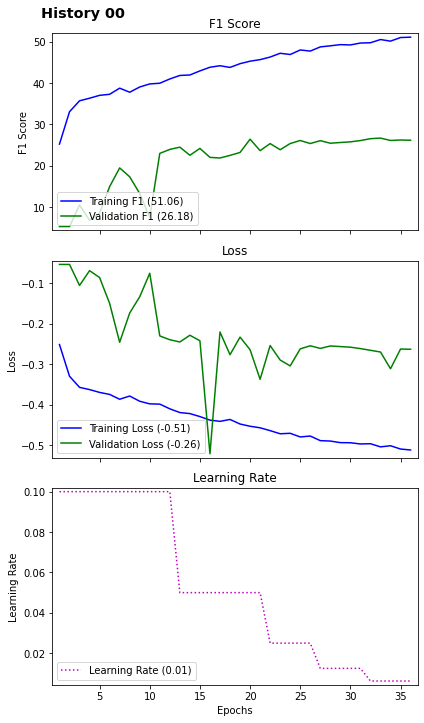

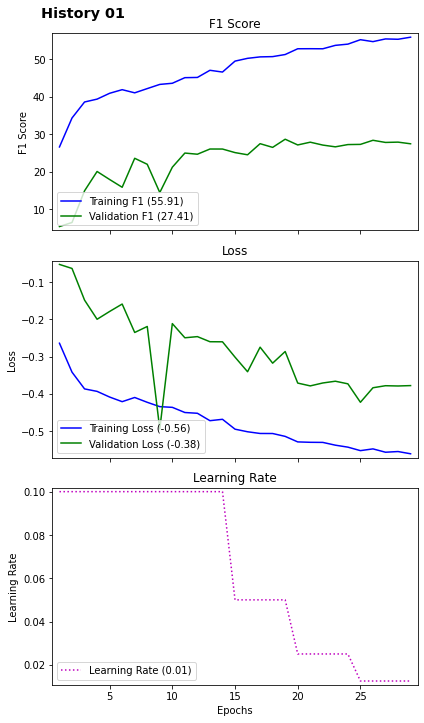

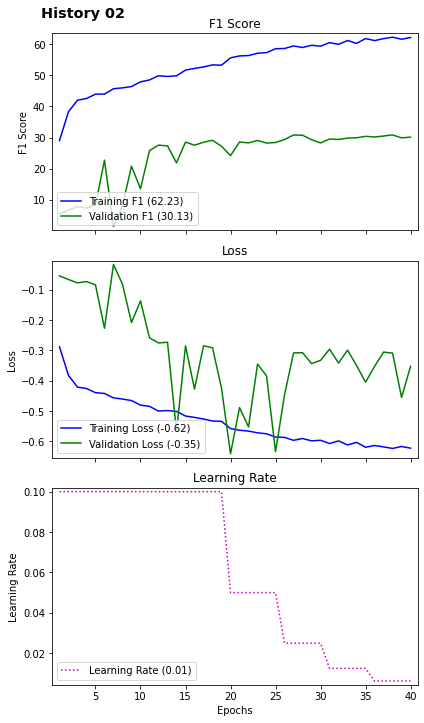

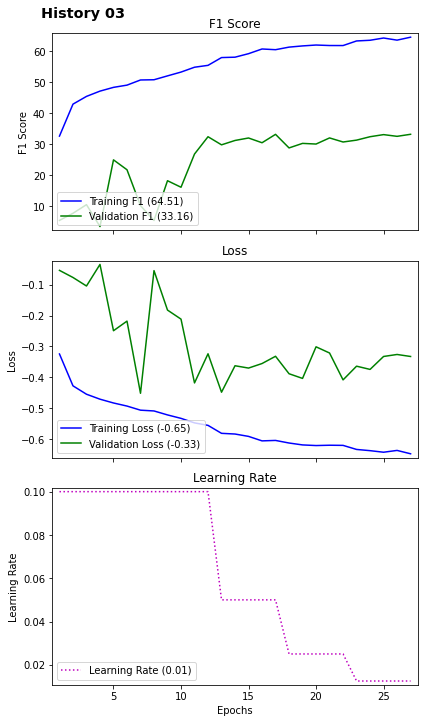

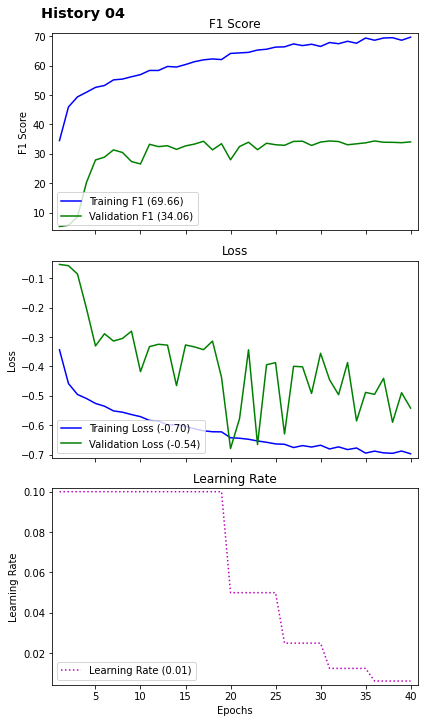

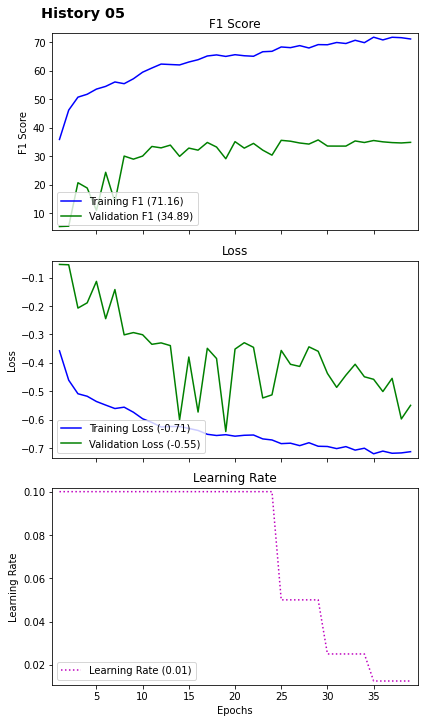

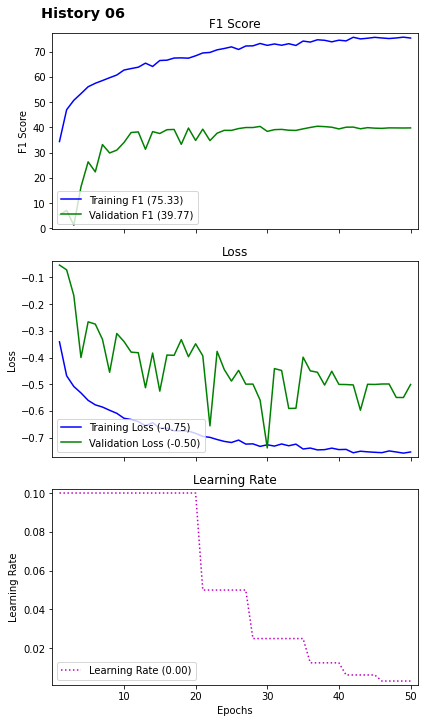

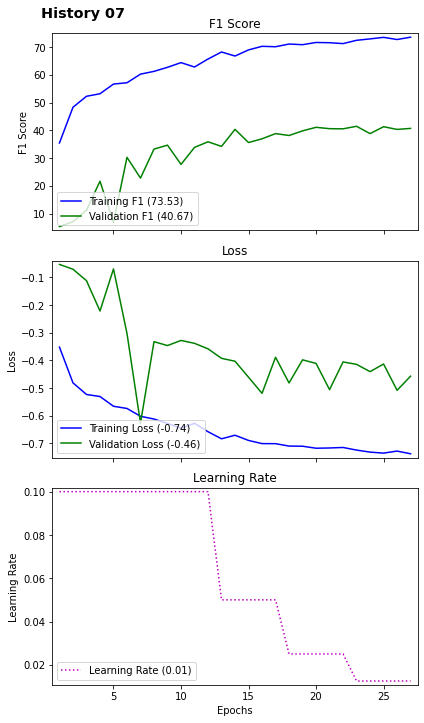

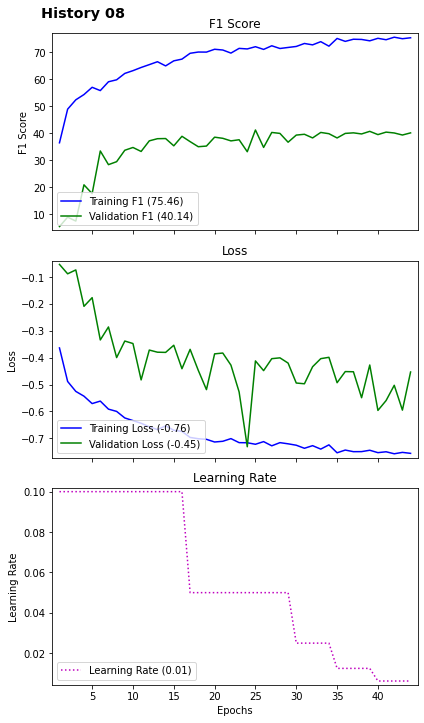

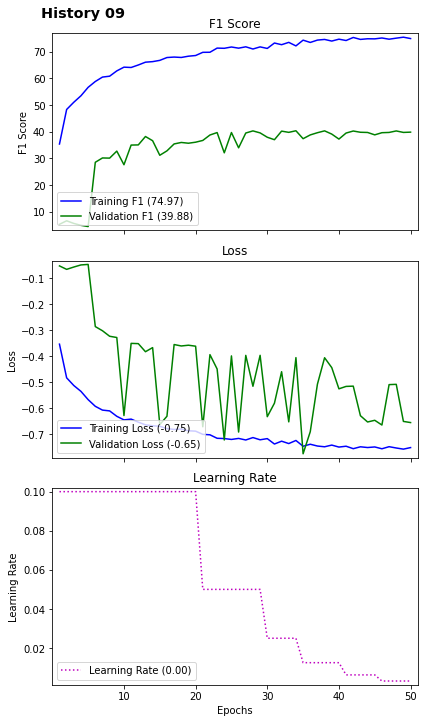

In [8]:
print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 14
Current Step: 10

EM Step 10 begun.
Sat at 11:22:51PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 10)
Sat at 11:23:16PM

Created New Annotation. (Step 10)
Sat at 11:25:48PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 10)
Sat at 11:25:53PM

New Learning Rate: 0.100000. (Step 10)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 10)
Sat at 11:32:04PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 11
 - F1_Score: 63.598
 - Dice_Score: 63.593
 - False_Positives: 6224700.000
 - False_Negatives: 4421900.000
 - Precision: 59.906
 - Recall: 67.776
 - Keras_Precision: 59.906
 - Keras_Recall: 67.776
 - Confusion Matrix: [[9835730   62247]
 [  44219   93004]]

Training Report 11
 - F1_Score: 73.454
 - Dice_Score: 73.454
 - False_Positives: 36211400.000
 - False_Negatives: 728446900.000
 - Precision: 79.985
 - Recall: 67.909
 - Keras_Precision: 84.746
 - Keras_Recall: 21.641
Validation Report 11
 - F1_Score: 61.999
 - Dice_Score: 61.998
 - False_Positives: 3008700.000
 - False_Negatives: 46644000.000
 - Precision: 71.270
 - Recall: 54.863
 - Keras_Precision: 77.792
 - Keras_Recall: 18.431

New Top F1: 63.60

New Top IoU: 36.19

EM Step (10) Complete on Sat at 11:32:29PM
- Annotation IoU:     36.19
	- Source Improvement: +17.93
	- Step Improvement:   +1.02

------ Times ---------------------
- Class Map Generation: 25.095 s
- Annotation Update:    143.099 s
- Model Training

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 12
 - F1_Score: 65.081
 - Dice_Score: 65.081
 - False_Positives: 6948600.000
 - False_Negatives: 3751300.000
 - Precision: 58.932
 - Recall: 72.663
 - Keras_Precision: 58.932
 - Keras_Recall: 72.663
 - Confusion Matrix: [[9828491   69486]
 [  37513   99710]]

Training Report 12
 - F1_Score: 74.853
 - Dice_Score: 74.850
 - False_Positives: 36910900.000
 - False_Negatives: 720981600.000
 - Precision: 80.207
 - Recall: 70.169
 - Keras_Precision: 84.893
 - Keras_Recall: 22.341
Validation Report 12
 - F1_Score: 62.650
 - Dice_Score: 62.648
 - False_Positives: 2929100.000
 - False_Negatives: 46250300.000
 - Precision: 71.634
 - Recall: 55.668
 - Keras_Precision: 78.612
 - Keras_Recall: 18.882

New Top F1: 65.08

EM Step (11) Complete on Sat at 11:46:25PM
- Annotation IoU:     34.86
	- Source Improvement: +16.60
	- Step Improvement:   -1.33

------ Times ---------------------
- Class Map Generation: 25.574 s
- Annotation Update:    142.598 s
- Model Training:       628.445 s
- 

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 13
 - F1_Score: 66.082
 - Dice_Score: 66.081
 - False_Positives: 6705300.000
 - False_Negatives: 3642300.000
 - Precision: 60.053
 - Recall: 73.457
 - Keras_Precision: 60.053
 - Keras_Recall: 73.457
 - Confusion Matrix: [[9830924   67053]
 [  36423  100800]]

Training Report 13
 - F1_Score: 76.152
 - Dice_Score: 76.151
 - False_Positives: 35191600.000
 - False_Negatives: 716371200.000
 - Precision: 81.320
 - Recall: 71.601
 - Keras_Precision: 85.654
 - Keras_Recall: 22.678
Validation Report 13
 - F1_Score: 65.107
 - Dice_Score: 65.102
 - False_Positives: 2726500.000
 - False_Negatives: 46131600.000
 - Precision: 74.079
 - Recall: 58.073
 - Keras_Precision: 80.265
 - Keras_Recall: 19.379

New Top F1: 66.08

EM Step (12) Complete on Sat at 11:59:07PM
- Annotation IoU:     35.45
	- Source Improvement: +17.19
	- Step Improvement:   +0.59

------ Times ---------------------
- Class Map Generation: 25.954 s
- Annotation Update:    139.918 s
- Model Training:       556.633 s
- 

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 14
 - F1_Score: 66.683
 - Dice_Score: 66.680
 - False_Positives: 7324800.000
 - False_Negatives: 3194800.000
 - Precision: 58.970
 - Recall: 76.718
 - Keras_Precision: 58.970
 - Keras_Recall: 76.718
 - Confusion Matrix: [[9824729   73248]
 [  31948  105275]]

Training Report 14
 - F1_Score: 77.542
 - Dice_Score: 77.543
 - False_Positives: 36583900.000
 - False_Negatives: 708260200.000
 - Precision: 81.210
 - Recall: 74.191
 - Keras_Precision: 85.552
 - Keras_Recall: 23.421
Validation Report 14
 - F1_Score: 66.413
 - Dice_Score: 66.413
 - False_Positives: 2778500.000
 - False_Negatives: 45590400.000
 - Precision: 74.143
 - Recall: 60.143
 - Keras_Precision: 80.459
 - Keras_Recall: 20.060

New Top F1: 66.68

EM Step (13) Complete on Sun at 12:11:56AM
- Annotation IoU:     35.87
	- Source Improvement: +17.62
	- Step Improvement:   +0.42

------ Times ---------------------
- Class Map Generation: 28.918 s
- Annotation Update:    139.613 s
- Model Training:       559.503 s
- 

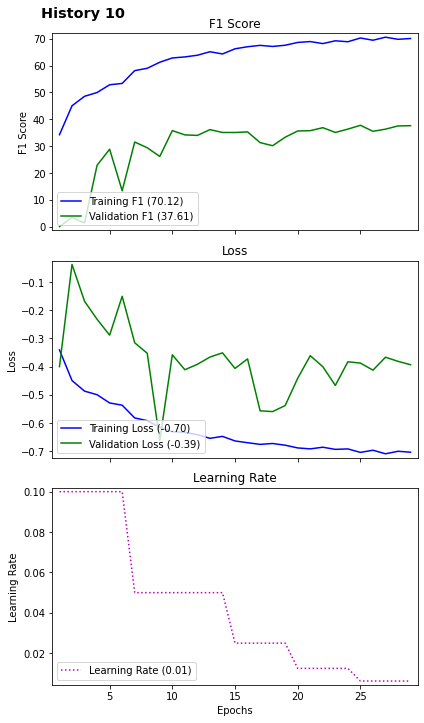

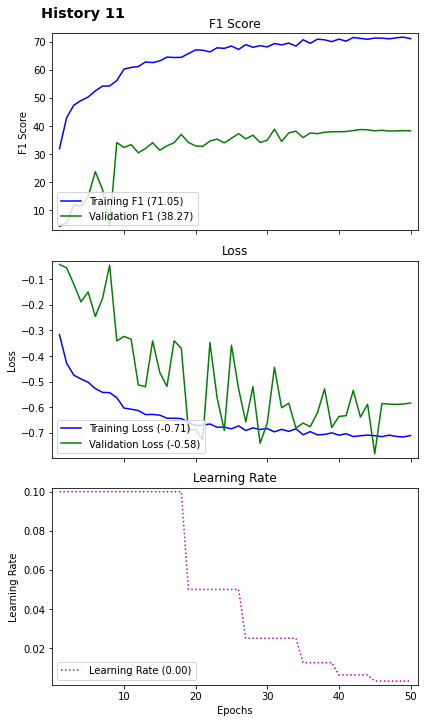

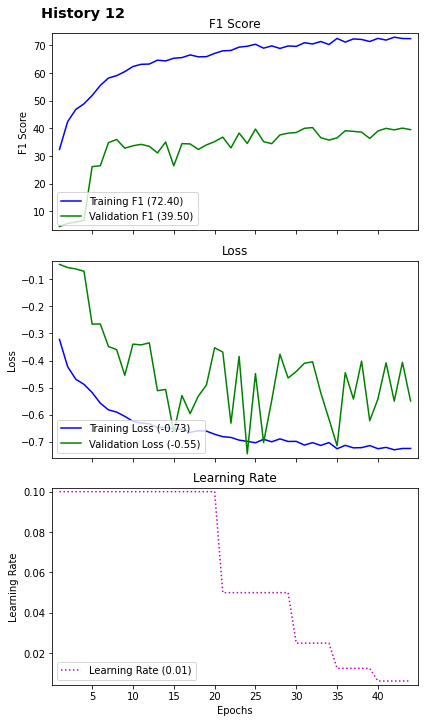

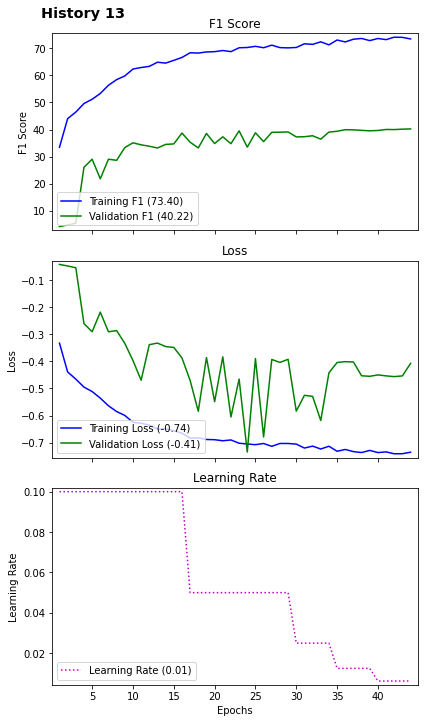

In [9]:
em_target = 14
buff_dist = 3

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


In [ ]:
buff_dist = 2

em_target = 14

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1

### Create Plots

In [ ]:
# Clean data for easy indexing

## Converts each of the report lists into a dict of lists for each value
model_dict = {'Test_Data': {}, 'Train_Data': {}, 'Val_Data': {}}
for em_key in model_dict.keys():
    for report in em_dict[em_key]:
        for rpt_key, rpt_value in [(key, item) for key, item in report.items()]:
            if rpt_key not in model_dict[em_key].keys():
                model_dict[em_key].update({rpt_key: np.array([rpt_value])})
            else:
                model_dict[em_key][rpt_key] = np.append(model_dict[em_key][rpt_key], report[rpt_key])


# Create Figure for Plots
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(16,10))

## Plot Testing F1
doc.plot_axis(ax=axs[0,0], 
              data=model_dict['Test_Data']['F1_Score']*100, 
              name='Testing F1', 
              color_char='r', 
              symbol_char='s', 
              y_off=2,
              label_delta=False)

## Plot Training F1
doc.plot_axis(ax=axs[0,1], 
              data=model_dict['Train_Data']['F1_Score']*100, 
              name='Training F1', 
              color_char='g', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Validation F1
doc.plot_axis(ax=axs[1,0], 
              data=model_dict['Val_Data']['F1_Score']*100, 
              name='Validation F1', 
              color_char='c', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Annotation IoU
doc.plot_axis(ax=axs[1,1], 
              data=em_dict['Line_IoU'], 
              name='Line IoU', 
              color_char='m', 
              x_label='EM Step',
              label_delta=False)
    
## Title and show, and save figure
fig.suptitle("EM Test {:02}".format(test_idx))
fig_path = os.path.join(test_dir, 'test_{:02}_plot.png'.format(test_idx))
fig.savefig(fig_path)
fig.show()


### Save to Markdown

Saves:
- Annotator Config
- Model Config
- EM preformance table
- Model preformance table

In [ ]:
### Write test data to markdown
markdown_fp = os.path.join(test_dir, 'em_test_info_{:02}.md'.format(test_idx))
md = open(markdown_fp, 'w+')

# Header / Notes
md.write("# EM Test {:02}\n\n".format(test_idx))

if (len(test_notes) > 0):
    md.write("### Notes: \n")
    md.write(test_notes)

md.write(dt.now().strftime('\n%a at %I:%M:%S%p'))
    
md.write("\n\n---\n\n")

# prepare peak values
top_f1 = np.round((top_f1*100), 3)
source_f1 = np.round((em_dict['Test_Data'][0]['F1_Score']*100), 3)
source_iou = np.round(source_iou*100, 2)

# Note at top the peak values 
md.write("### Top Values:\n\n")
md.write(" - Testing F1 Score: **{:.2f}** (`{:+.2f}`) - Step {:02}\n".format(top_f1, (top_f1-source_f1), top_f1_idx))
md.write(" - Annotation IoU: **{:.2f}** (`{:+.2f}`) - Step {:02}\n\n\n".format(top_iou, (top_iou-source_iou), top_iou_idx))



# Test Configuration Section
md.write("## **Test Config**\n\n")

md.write("### Seeds:\n")
md.write("`Python`: {}, `Numpy`: {}, `Tensorflow`: {}\n\n".format(py_seed, np_seed, tf_seed))

md.write("### Annotator:\n")
for key, item in annotator.__dict__.items():
    
    # Skip gross keys
    if key in ['verbosity', 'crop_window', 'class_map', 'kwargs_key', 'crs']:
        continue
    
    # Write key and item
    md.write("- `{}`: {}\n".format(key, item))
        
md.write("\n\n")

md.write("### Model:\n")
md.write("- **Training**:\n")
md.write("  - `Batch Size`: {}\n".format(batch_size))
md.write("  - `Learning Rate`: {}\n".format(learning_rate))
md.write("  - `Epochs`: {}\n".format(epochs))
md.write("- **Callbacks**:\n")
md.write("  - `ES Patience`: {}\n".format(es_patience))
md.write("  - `RLOP Factor`: {}\n".format(rlop_factor))
md.write("  - `Adam Epsilon`: {}\n".format(adam_epsilon))
md.write("  - `Adam Decay`: {}\n".format(adam_decay))

md.write("\n\n")

md.write("### Other:\n")
md.write("- EM Steps: {}\n".format(em_target))
md.write("- ClassMap: '{}'\n".format(seg_class_map_fp))


md.write("\n---\n\n")


# Results Section

md.write("## **Results**:\n\n")

md.write("### EM Iteration:\n\n")

md.write("Step | Anno IoU | F1 | Epochs | LR | Train | Update\n")
md.write("---- | -------- | -- | ------ | -- | ----- | ------\n")
for idx in range(em_target):
    if idx == 0:
        md.write("{} | {} | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))
    else:
        md.write("{} | {} (`{:+.2f}`) | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], (em_dict['Line_IoU'][idx] - em_dict['Line_IoU'][0]), em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))

md.write("\n\n</br>\n\n")
    
md.write("### Model Performance:\n\n")
md.write("Step | Test F1 | Test (FP, FN) | Train F1 | Train (FP, FN) | Val F1 | Val (FP, FN) | LR \n")
md.write("---- | ------- | ------------- | -------- | -------------- | ------ | ------------ | -- \n")
for idx in range(em_target):
    # Create a string to hold this row's data
    row_string = "{} | ".format(em_dict['Name'][idx])
    
    # Iterate over F1 types
    for key in ['Test_Data', 'Train_Data', 'Val_Data']:
        
        if idx == 0:
            row_string += "{:.2f} | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
        else:
            row_string += "{:.2f} (`{:+.2f}`) | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, (em_dict[key][idx]['F1_Score']*100 - em_dict[key][0]['F1_Score']*100), em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
      
    # After all sets have been added, append learning rate and newline
    row_string += "{}\n".format(em_dict['LR'][idx])
    md.write(row_string)


# Close Markdown
md.close()

print("Config and results written to markdown.")
print("Location:", markdown_fp)